#Sentiment classification on movie reviews

In [1]:
############################
### Required environment ###
############################
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

## 1) 데이터 준비와 확인

Dataset
- [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/Exploration/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/Exploration/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#################
### Load data ###
#################
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
#######################
### Word dictionary ###
#######################
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
#################
### Functions ###
#################
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공

In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

print('--------------------------------------------------')

print("train 문장 길이: ", len(X_train))
print("test 문장 길이: ", len(X_test))

print('--------------------------------------------------')

# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것 잊으면 안됨!
# 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미침
# 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋음
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

print('--------------------------------------------------')

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

훈련 샘플 개수: 146182, 테스트 개수: 49157
--------------------------------------------------
train 문장 길이:  146182
test 문장 길이:  49157
--------------------------------------------------
문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
--------------------------------------------------
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4) 모델구성 및 validation set 구성

- LSTM 외에도 1-D CNN과 RNN 레이어를 섞어 쓴다거나, FFN(FeedForward Network) 레이어만으로 구성하거나, 
- 혹은 최근 각광받고 있는 Transformer 레이어를 쓰는 등 매우 다양한 시도 가능

In [9]:
############
### LSTM ###
############
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 코드
vocab_size = 10000  # 어휘 사전의 크기 (10000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(8)) # RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.initializers import Constant
################
### Conv1D ###
################
model_Conv1d = keras.Sequential()
model_Conv1d.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Conv1d.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1d.add(keras.layers.MaxPooling1D(5))
model_Conv1d.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1d.add(keras.layers.GlobalMaxPooling1D())
model_Conv1d.add(keras.layers.Dense(8, activation='relu'))
model_Conv1d.add(keras.layers.Dense(1, activation='sigmoid')) 

model_Conv1d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
##########################
### GlobalMaxPooling1D ###
##########################
model_gmp1d = keras.Sequential()
model_gmp1d.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [12]:
######################
### Data splitting ###
######################
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(136182, 41)
(136182,)
(10000, 41)
(10000,)


## 5) 모델 훈련 개시

In [13]:
############
### LSTM ###
############
model_lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_lstm = model_lstm.fit(partial_X_train,
                         partial_y_train,
                         epochs=epochs,
                         batch_size=64,
                         validation_data=(X_val, y_val),
                         verbose=1)

Epoch 1/5
2128/2128 [==============================] - 13s 5ms/step - loss: 0.4116 - accuracy: 0.8015 - val_loss: 0.3386 - val_accuracy: 0.8511
Epoch 2/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3228 - accuracy: 0.8609 - val_loss: 0.3338 - val_accuracy: 0.8577
Epoch 3/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2967 - accuracy: 0.8714 - val_loss: 0.3333 - val_accuracy: 0.8556
Epoch 4/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2750 - accuracy: 0.8826 - val_loss: 0.3293 - val_accuracy: 0.8554
Epoch 5/5
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2559 - accuracy: 0.8919 - val_loss: 0.3347 - val_accuracy: 0.8585


In [14]:
################
### Conv1D ###
################
model_Conv1d.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_Conv1d = model_Conv1d.fit(partial_X_train,
                         partial_y_train,
                         epochs=epochs,
                         batch_size=64,
                         validation_data=(X_val, y_val),
                         verbose=1)

Epoch 1/5
2128/2128 [==============================] - 9s 4ms/step - loss: 0.3906 - accuracy: 0.8198 - val_loss: 0.3322 - val_accuracy: 0.8499
Epoch 2/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.3000 - accuracy: 0.8733 - val_loss: 0.3220 - val_accuracy: 0.8571
Epoch 3/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.2527 - accuracy: 0.8972 - val_loss: 0.3316 - val_accuracy: 0.8538
Epoch 4/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.2044 - accuracy: 0.9203 - val_loss: 0.3666 - val_accuracy: 0.8489
Epoch 5/5
2128/2128 [==============================] - 8s 4ms/step - loss: 0.1624 - accuracy: 0.9392 - val_loss: 0.4081 - val_accuracy: 0.8470


In [15]:
##########################
### GlobalMaxPooling1D ###
##########################
model_gmp1d.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_gmp1d = model_gmp1d.fit(partial_X_train,
                         partial_y_train,
                         epochs=epochs,
                         batch_size=64,
                         validation_data=(X_val, y_val),
                         verbose=1)

Epoch 1/5
2128/2128 [==============================] - 7s 3ms/step - loss: 0.4277 - accuracy: 0.8052 - val_loss: 0.3483 - val_accuracy: 0.8430
Epoch 2/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.3245 - accuracy: 0.8605 - val_loss: 0.3417 - val_accuracy: 0.8501
Epoch 3/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.2930 - accuracy: 0.8770 - val_loss: 0.3464 - val_accuracy: 0.8506
Epoch 4/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.2722 - accuracy: 0.8876 - val_loss: 0.3519 - val_accuracy: 0.8493
Epoch 5/5
2128/2128 [==============================] - 6s 3ms/step - loss: 0.2553 - accuracy: 0.8950 - val_loss: 0.3641 - val_accuracy: 0.8468


In [16]:
#######################
### Evaluate models ###
#######################
results_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
history_dict_lstm = history_lstm.history
print(history_dict_lstm.keys())
print('--------------------------------------------------')
results_Conv1d = model_Conv1d.evaluate(X_test, y_test, verbose=2)
print(results_Conv1d)
history_dict_Conv1d = history_Conv1d.history
print(history_dict_Conv1d.keys())
print('--------------------------------------------------')
results_gmp1d = model_gmp1d.evaluate(X_test, y_test, verbose=2)
print(results_gmp1d)
history_dict_gmp1d = history_gmp1d.history
print(history_dict_gmp1d.keys())

1537/1537 - 3s - loss: 0.3446 - accuracy: 0.8550
[0.3446462154388428, 0.8550359010696411]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
--------------------------------------------------
1537/1537 - 2s - loss: 0.4170 - accuracy: 0.8429
[0.41701534390449524, 0.8428911566734314]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
--------------------------------------------------
1537/1537 - 2s - loss: 0.3799 - accuracy: 0.8419
[0.37986570596694946, 0.8419146537780762]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6) Loss, Accuracy 그래프 시각화

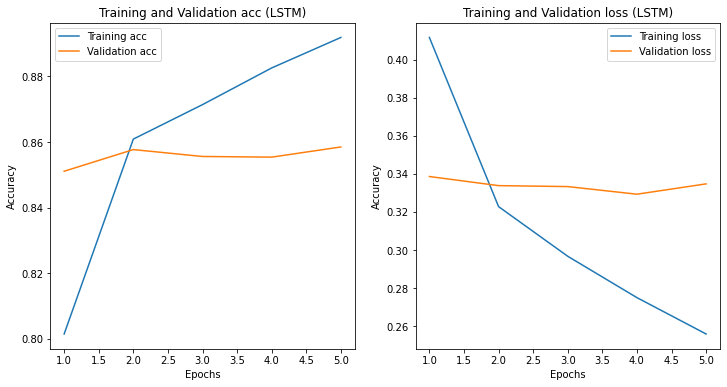

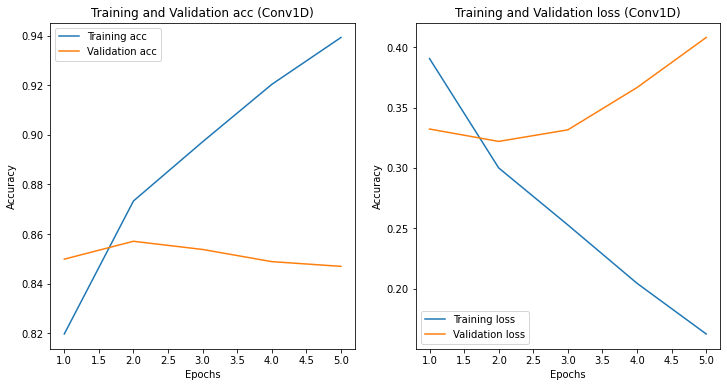

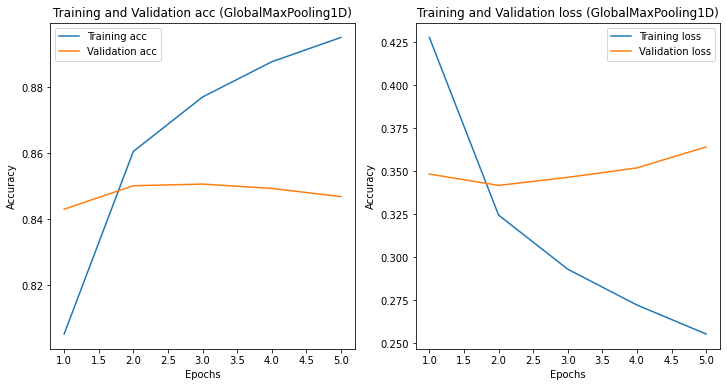

In [17]:
############################
### Result visualization ###
############################
import matplotlib.pyplot as plt
def showLossAcc(history, model):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # Accuracy 그래프
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation acc ({model})')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation loss ({model})')
    plt.legend()

    plt.show()

showLossAcc(history_lstm, 'LSTM')
showLossAcc(history_Conv1d, 'Conv1D')
showLossAcc(history_gmp1d, 'GlobalMaxPooling1D')

## 7) 학습된 Embedding 레이어 분석

In [18]:
################################
### Embedding layer analysis ###
################################
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

print('-------------------------------------------------------------------')

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = r'/content/drive/MyDrive/AIFFEL/Exploration/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)
-------------------------------------------------------------------


In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
print(vector)

print('-------------------------------------------------------------------')

word_vectors.similar_by_word("감동")

[ 0.12685348  0.14075756  0.21153906  0.17870992 -0.05733664  0.27301943
  0.13577831 -0.1650144  -0.23596852  0.08393467 -0.23203617 -0.42629763
 -0.31122985 -0.23886299 -0.19823569 -0.2632329 ]
-------------------------------------------------------------------


[('간만에', 0.9824123382568359),
 ('그리고', 0.9714379906654358),
 ('여하튼', 0.9710614085197449),
 ('열린', 0.9683781862258911),
 ('가벼움', 0.9682715535163879),
 ('므', 0.9678347110748291),
 ('스포츠', 0.9674957990646362),
 ('낭만', 0.9664721488952637),
 ('인상깊', 0.9659478664398193),
 ('왜냐하면', 0.9659123420715332)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

한국어 Word2Vec
- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

In [20]:
###################################
### Pre-trained Korean Word2Vec ###
###################################
from gensim.models import Word2Vec
word2vec_path = r'/content/drive/MyDrive/AIFFEL/Exploration/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(200,)

In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

############
### LSTM ###
############
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm.add(keras.layers.LSTM(256)) # RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 256
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_lstm.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [22]:
################
### Training ###
################
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                         partial_y_train,
                         epochs=epochs,
                         batch_size=512,
                         validation_data=(X_val, y_val),
                         verbose=1)

Epoch 1/20
266/266 [==============================] - 7s 20ms/step - loss: 0.5596 - accuracy: 0.6682 - val_loss: 0.3735 - val_accuracy: 0.8354
Epoch 2/20
266/266 [==============================] - 5s 19ms/step - loss: 0.3368 - accuracy: 0.8544 - val_loss: 0.3182 - val_accuracy: 0.8604
Epoch 3/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2834 - accuracy: 0.8809 - val_loss: 0.3117 - val_accuracy: 0.8654
Epoch 4/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2503 - accuracy: 0.8974 - val_loss: 0.3146 - val_accuracy: 0.8657
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.2205 - accuracy: 0.9106 - val_loss: 0.3298 - val_accuracy: 0.8655
Epoch 6/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1891 - accuracy: 0.9254 - val_loss: 0.3327 - val_accuracy: 0.8665
Epoch 7/20
266/266 [==============================] - 5s 18ms/step - loss: 0.1604 - accuracy: 0.9383 - val_loss: 0.3689 - val_accuracy: 0.8660

In [23]:
################
### Evaluate ###
################
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7344 - accuracy: 0.8545
[0.7344004511833191, 0.8544866442680359]


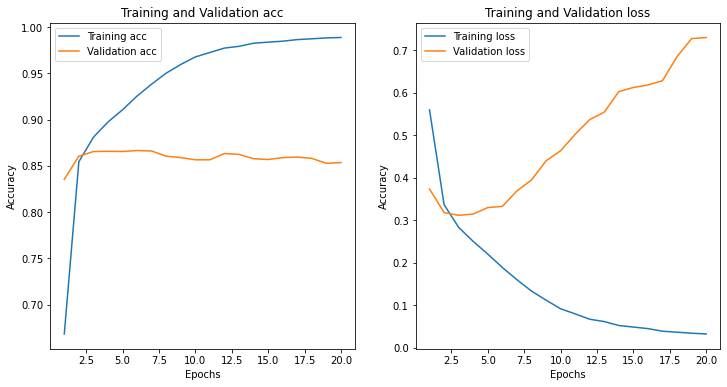

In [24]:
############################
### Result visualization ###
############################
history_dict = history_lstm.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation acc')
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

결론
- LSTM, Conv1D, GlobalMaxPooling1D 를 사용하여 Text Classification을 시도함
- `gensim`을 활용하여 자체학습 및 사전학습 임베딩 레이어를 분석함
- 한국어 Word2Vec를 활용하여 네이버 영화리뷰 데이터 감성분석 정확도 85.45% 달성함    
(모델은 앞의 결과에서 성능이 그나마 괜찮아 보이는 LSTM 사용)